# I. PEMAHAMAN DOMAIN DAN TUJUAN

## 1.1. Pemahaman Penyakit Ginjal Kronis

>Penyakit Ginjal Kronis (PGK) adalah suatu proses patofisiologis dengan etiologi yang beragam, mengakibatkan penurunan fungsi ginjal yang progresif, penurunan fungsi ini bersifat kronis dan irreversible.

>Data didapatkan dari UCI Machine Learning Repository. Berisikan 400 data dan memiliki 25 atribut, terdiri dari 1 kelas target dan 24 atribut. 

## 1.2. Tujuan

>Identifikasi PGK dengan atribut yang paling berpengaruh

# II. PEMBUATAN DATASET DAN TARGET

## 2.1 Data UCI

Data didapat dari: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

Data tersebut di-import dalam mariaDB

In [1]:
import numpy as np
import pandas as pd
import pymysql as pskl
import matplotlib.pyplot as plt

# Menampilkan semua array
# np.set_printoptions(threshold=np.nan)

In [2]:
def dataset(retrieve="all", id=0, target=0): #hasil bertipe dataframe
    """
    parameters
    ----------
    retrieve: (all, numeric, polinom)
        all    : semua kolom
        numeric: hanya kolom numeric
        polinom: hanya kolom polinom
    id: (0, 1)
        0: tanpa kolom id
        1: dengan kolom id
    class: (0, 1)
        0: tanpa kolom class
        1: dengan kolom class
    
    """
    connection = pskl.connect(host="localhost", user="root", passwd="", database="knn")
    cursor = connection.cursor()
    if(retrieve=="all"):
        cols = ["id", "age", "bp", "sg", "al", "su", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc", "rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "class"]
        retrieve = "SELECT id, age, bp, sg, al, su, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc, rbc, pc, pcc, ba, htn, dm, cad, appet, pe, ane, class FROM ckd_preprocessing3"
    elif(retrieve=="numeric"):
        cols = ["id", "age", "bp", "sg", "al", "su", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc", "class"]
        retrieve = "SELECT id, age, bp, sg, al, su, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc, class FROM ckd_preprocessing3"
    elif(retrieve=="polinom"):
        cols = ["id", "rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "class"]
        retrieve = "SELECT id, rbc, pc, pcc, ba, htn, dm, cad, appet, pe, ane, class FROM ckd_preprocessing3"
    resolveall = cursor.execute(retrieve)
    rows_tupple = cursor.fetchall()
    data = pd.DataFrame(list(rows_tupple))
    data.columns = cols
    if(id==0):
        data = data.drop(["id"], axis=1)
    if(target==0):
        data = data.drop(["class"], axis=1)
    data = data.fillna(value=np.nan) #mengubah missing value menjadi NaN
    return data

In [3]:
numeric_df = dataset(retrieve="numeric")
numeric_df.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6


In [4]:
numeric_df.shape

(400, 14)

## 2.2. Menentukan Atribut Target

>Atribut "class" sebagai target dataset

outputnya target

# III. DATA CLEANING DAN PREPROCESSING

## 3.1 Menghilangkan Outliers

>referensi: http://digilib.unila.ac.id/20585/4/II.%20TINJAUAN%20PUSTAKA.pdf

In [5]:
def outliers(df, k1=0.25, k3=0.75):
    """
    parameters:
    -----------
    df: input tipe dataframe, hanya menerima numeric
    
    mendeteksi data yang diluar batas bawah dan batas atas
    batas bawah = k1 - (k3-k1)*1.5
    batas atas = k3 + (k3-k1)*1.5
    """
    pencilan = df.apply(lambda x: (x < df[x.name].quantile(k1)-((df[x.name].quantile(k3)-df[x.name].quantile(k1))*1.5))|(x > df[x.name].quantile(k3)+((df[x.name].quantile(k3)-df[x.name].quantile(k1))*1.5)), axis=0)
    return pencilan

In [6]:
pencilan = outliers(numeric_df)
pencilan.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
def outliers_removing(df, pencilan):
    """
    paramters:
    ----------
    df: input tipe dataframe
    pencilan: input tipe dataframe, bertipe boolean
    
    output:
    -------
    mengembalikan dataframe yang sudah menghilangkan semua outliers (semua baris yang berisi nilai pencilan true)
    """
    filtered_df = df[~(pencilan).any(axis=1)]
    return filtered_df

In [8]:
df = dataset(retrieve="all", id=1, target=1)

filtered_df = outliers_removing(df, pencilan)
filtered_df.head()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,1,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
4,5,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
5,6,60.0,90.0,1.015,3.0,0.0,74.0,25.0,1.1,142.0,...,NaN,notpresent,notpresent,yes,yes,no,good,yes,no,ckd
13,14,68.0,70.0,NaN,NaN,NaN,98.0,86.0,4.6,135.0,...,NaN,notpresent,notpresent,yes,yes,yes,poor,yes,no,ckd
16,17,47.0,70.0,1.015,2.0,0.0,99.0,46.0,2.2,138.0,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [9]:
filtered_df.shape

(251, 26)

# IV. TRANSFORMASI DATA

## 4.1 Data Nominal Menjadi Numeric

>Mengubah atribut / kolom polinom menjadi numerik

>Dikarenakan semua kolom nominal hanya memiliki 2 kelas (binary), hasil transformasi menjadi 0 dan 1

In [10]:
def encoding(df, column="all_nominal"):
    """
    paramters:
    ----------
    df: input tipe dataframe
    column: input tipe string, menentukan kolom nominal mana yang akan di transformasi menjadi numerik
    
    output:
    ----------
    mengembalikan dataframe dengan kolom tertentu yang sudah di encode selain "NaN"
    
    """
    #python melakukan pass by reference, sehingga dibuat copy agar df sebelumnya tidak berubah
    
    copy_df = df.copy()
    if(column!="all_nominal"):
        a = copy_df[column].unique().tolist()
        c = [x for x in a if str(x) != 'nan']
        l=[]
        i=0
        for x in c:
            l.append(i)
            i+=1
        copy_df[column] = copy_df[column].replace(c, l)
    
    elif(column=="all_nominal"):
        all_nominal = ["rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane","class"]
        for col in all_nominal:
            copy_df = encoding(copy_df, col) #rekursif
            
    return copy_df

In [11]:
encoded_df = encoding(filtered_df, "all_nominal")
encoded_df.head()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,1,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
5,6,60.0,90.0,1.015,3.0,0.0,74.0,25.0,1.1,142.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
13,14,68.0,70.0,NaN,NaN,NaN,98.0,86.0,4.6,135.0,...,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0
16,17,47.0,70.0,1.015,2.0,0.0,99.0,46.0,2.2,138.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [12]:
encoded_df.shape

(251, 26)

## 4.2 Penanganan Data yang Hilang

Mengubah NaN menjadi strategi tertentu, dalam hal ini diubah menjadi rata - rata dari setiap kolom

In [13]:
from sklearn.preprocessing import Imputer

In [14]:
def missing_handling(df, column="all", method="mean"):
    """
    paramters:
    ----------
    df: input tipe dataframe
    column: menentukan kolom numerik mana yang akan dilakukan penanganan missing value
    method: strategi penanganan missing value
    
    output:
    ----------
    mengembalikan dataframe dengan kolom yang sudah dilakukan penanganan NaN
    """
    
    copy_df = df
    imputer = Imputer(missing_values="NaN", strategy=method, axis = 0)    
    
    if(column!="all"):
        imputer = imputer.fit(copy_df[[column]])
        filledmissing_df = imputer.transform(copy_df[[column]])
        df_change = filledmissing_df.ravel()    
        copy_df[column] = df_change
        
    elif(column=="all"):
        all_col = ["age", "bp", "sg", "al", "su", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc", "rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "class"]
        for col in all_col:
            copy_df = missing_handling(copy_df, col, method) #rekursif
    return copy_df

In [15]:
missing_handling_df = missing_handling(encoded_df, "all")
missing_handling_df.head()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,1,48.0,80.0,1.020000,1.000000,0.0,121.0,36.0,1.2,140.50495,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,51.0,80.0,1.010000,2.000000,0.0,106.0,26.0,1.4,140.50495,...,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6,60.0,90.0,1.015000,3.000000,0.0,74.0,25.0,1.1,142.00000,...,0.100917,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,14,68.0,70.0,1.019432,0.458515,0.0,98.0,86.0,4.6,135.00000,...,0.100917,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
16,17,47.0,70.0,1.015000,2.000000,0.0,99.0,46.0,2.2,138.00000,...,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
missing_handling_df.shape

(251, 26)

## 4.3 Normalisasi

>Melakukan normalisasi data, agar range tiap atribut sama dan tidak ada yang dominan saat perhitungan

$$Xnorm = \frac{X - min(X)}{max(X)-min(X)}$$

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
def normalizing(df, column="all", f_range=(0,1)):
    """
    paramters:
    ----------
    df: input tipe dataframe
    column: menentukan kolom numerik mana yang akan dilakukan penanganan missing value
    range: range normalisasi
    
    output:
    ----------
    mengembalikan dataframe dengan kolom yang sudah dinormalisasi
    """
    
    copy_df = df.copy()
    scale = MinMaxScaler(feature_range=f_range)    
    
    if(column!="all"):
        normalization_array = scale.fit_transform(copy_df[[column]])
        df_change = normalization_array.ravel()    
        copy_df[column] = df_change
        
    elif(column=="all"):
        all_col = ["age", "bp", "sg", "al", "su", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wbcc", "rbcc", "rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane"]
        for col in all_col:
            copy_df = normalizing(copy_df, col, f_range) #rekursif
    return copy_df

In [19]:
normalized_df = normalizing(missing_handling_df, column="all", f_range=(0,1))
normalized_df.head()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,1,0.468354,0.666667,0.750000,0.250000,0.0,0.286517,0.250000,0.166667,0.620198,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.506329,0.666667,0.250000,0.500000,0.0,0.202247,0.153846,0.208333,0.620198,...,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,6,0.620253,1.000000,0.500000,0.750000,0.0,0.022472,0.144231,0.145833,0.680000,...,0.100917,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,14,0.721519,0.333333,0.721616,0.114629,0.0,0.157303,0.730769,0.875000,0.400000,...,0.100917,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
16,17,0.455696,0.333333,0.500000,0.500000,0.0,0.162921,0.346154,0.375000,0.520000,...,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
normalized_df.shape

(251, 26)

In [21]:
# path=r"C:\Users\Ikhsan\Desktop"
# import os
# normalized_df.to_csv(os.path.join(path,r'preprocessing.csv'))

# V. PENENTUAN TUGAS DATA MINING

>Tugas Data Mining yang dilakukan adalah klasifikasi

# VI. IMPLEMENTASI ALGORITMA DAN METODE

## 6.1 Klasifikasi

>Klasifikasi dengan algoritma kNN

## 6.2 Seleksi Atribut

>Seleksi atribut dengan Backward Elimination

# VI. Penentuan Algoritma dan Metode

## 6.1 Klasifikasi dengan kNN

In [22]:
import MyDir as my

## 6.2 Feature Selection dengan Backward Elimination

# VII. Implementasi Algoritma Data Mining

## 7.1 Mencari Nilai k Terbaik pada kNN

In [23]:
from sklearn.model_selection import KFold

In [24]:
def knn_kfold(df, kNN = 5, k_fold=10, shuffle_=False, arr_akurasi=0):
    """
    Parameter:
    ----------
    df : Dataframe, data bertipe float / integer, tidak boleh ada NaN
    kNN : Nilai k-tetangga/data terdekat, default = 5
    k_fold : Jumlah fold / lipatan split training - test. Default = 5
    shuffle_ : Bentuk shuffle split jika diperlukan. Default = False

    Ouput:
    -------
    arr_akurasi : 1 untuk menghasilkan output array akurasi tiap fold, 0 untuk rata - rata akurasi. default = 0
    """
    
    kf = KFold(n_splits = k_fold, shuffle = shuffle_, random_state=2)
    akurasi = []
    for train_index, test_index in kf.split(df):
        train_df = df.iloc[train_index]
        x_train = np.array(train_df.iloc[:,1:-1])
        y_train = np.array(train_df["class"])
        test_df = df.iloc[test_index]
        x_test = np.array(test_df.iloc[:,1:-1])
        y_test = np.array(test_df["class"])
    
        my_predictions = np.array([my.knn_predict(p, x_train, y_train, k=kNN) for p in x_test])
        akurasi_my_predictions = np.mean(my_predictions == y_test)*100
        akurasi.append(akurasi_my_predictions)
    if(arr_akurasi==1):
        return akurasi
    else:
        return np.mean(akurasi)

>Dikarenakan data target sudah terurut dari 0"notckd" terlebih dahulu kemudian 1"ckd", KFold dengan metode pengambilan data training dan data test secara random (shuffle=True) lebih baik, karena data training dan test terdistribusi lebih seimbang.

# TANPA Penghilangan Outliers TANPA Normalisasi (_1)

>## k kNN terbaik = 3, akurasi 76.75%

In [38]:
df_1 = dataset(target=1)
print(df.shape)
df_1.head()

(400, 26)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [26]:
encoded_df_1 = encoding(df_1)
print(encoded_df_1.shape)
encoded_df_1.head()

(400, 25)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [27]:
missing_handled_df_1 = missing_handling(encoded_df_1)
print(missing_handled_df_1.shape)
missing_handled_df_1.head()

(400, 25)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,137.528754,4.627244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,148.036517,18.0,0.8,137.528754,4.627244,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,137.528754,4.627244,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.528754,4.627244,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [28]:
akurasi_rand_True_1 = knn_kfold(missing_handled_df_1, kNN = 5, k_fold=10, shuffle_=True, arr_akurasi=0)
print(missing_handled_df_1.shape)
akurasi_rand_True_1

(400, 25)


74.5

In [33]:
akurasi_1 = []
maks_1 = 0
for i in range (2,11):
    akurasi_k = knn_kfold(missing_handled_df_1, kNN = i, k_fold=10, shuffle_=True, arr_akurasi=0)
    akurasi_1.append([i, akurasi_k])
    if(maks_1<akurasi_k):
        maks_1 =akurasi_k
        k = i
        print(k, maks_1)
akurasi_1

2 75.25
3 76.75


[[2, 75.25],
 [3, 76.75],
 [4, 75.5],
 [5, 74.5],
 [6, 70.75],
 [7, 73.75],
 [8, 72.75],
 [9, 72.25],
 [10, 72.0]]

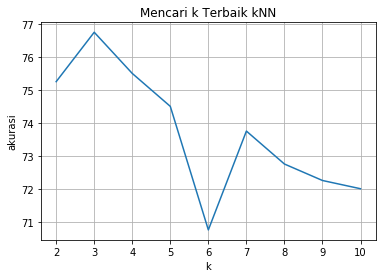

In [56]:
x = [i[0] for i in akurasi_1]
y = [i[1] for i in akurasi_1]
plt.plot(x,y)
plt.title("Mencari k Terbaik kNN")
plt.xlabel("k")
plt.ylabel("akurasi")
plt.grid()
plt.show()

# TANPA Penghilangan Outliers DENGAN Normalisasi (_2)

>## k terbaik 2 & 3, Akurasi = 99.75

In [40]:
df_2 = dataset(target=1)
print(df_2.shape)
df_2.head()

(400, 25)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [41]:
encoded_df_2 = encoding(df_2)
print(encoded_df_2.shape)
encoded_df_2.head()

(400, 25)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0


In [42]:
missing_handled_df_2 = missing_handling(encoded_df_2)
print(missing_handled_df_2.shape)
missing_handled_df_2.head()

(400, 25)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,137.528754,4.627244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,148.036517,18.0,0.8,137.528754,4.627244,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,137.528754,4.627244,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,137.528754,4.627244,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [43]:
normalized_df_2 = normalizing(missing_handled_df_2)
print(normalized_df_2.shape)
normalized_df_2.head()

(400, 25)


,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,0.522727,0.230769,0.75,0.2,0.0,0.211538,0.088575,0.010582,0.839298,0.047803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.056818,0.000000,0.75,0.8,0.0,0.269309,0.042362,0.005291,0.839298,0.047803,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.681818,0.230769,0.25,0.4,0.6,0.856838,0.132221,0.018519,0.839298,0.047803,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.522727,0.153846,0.00,0.8,0.0,0.202991,0.139923,0.044974,0.671924,0.000000,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
4,0.556818,0.230769,0.25,0.4,0.0,0.179487,0.062901,0.013228,0.839298,0.047803,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
akurasi_rand_True_2 = knn_kfold(normalized_df_2, kNN = 5, k_fold=10, shuffle_=True, arr_akurasi=0)
print(normalized_df_2.shape)
akurasi_rand_True_2

(400, 25)


99.25

In [53]:
akurasi_2 = []
maks_2 = 0
for i in range (2,11):
    akurasi_k = knn_kfold(normalized_df_2, kNN = i, k_fold=10, shuffle_=True, arr_akurasi=0)
    akurasi_2.append([i, akurasi_k])
    if(maks_2<=akurasi_k):
        maks_2 =akurasi_k
        k = i
        print(k, maks_2)
akurasi_2

2 99.75
3 99.75


[[2, 99.75],
 [3, 99.75],
 [4, 99.25],
 [5, 99.25],
 [6, 99.25],
 [7, 99.0],
 [8, 99.0],
 [9, 98.75],
 [10, 98.5]]

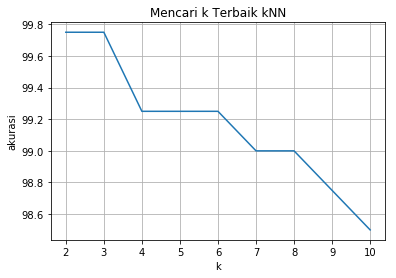

In [57]:
x = [i[0] for i in akurasi_2]
y = [i[1] for i in akurasi_2]
plt.plot(x,y)
plt.title("Mencari k Terbaik kNN")
plt.xlabel("k")
plt.ylabel("akurasi")
plt.grid()
plt.show()